# Predicting Bike Rentals
### (Testing and Comparing 8 Machine Learning Models)

The goal of this project will be to predict the total number of bikes rented within an hour in the District of Columbia in the United States of America. There are communal bike sharing stations where you can rent bicycles by the hour or day and the District collects detailed data on the number of bicycles people rent by the hour and day.

Apart from being an interesting and important real world mobility solutions, the characteristics of data being generated by bike sharing systems make them attractive for the research. Opposed to other transport services such as bus or subway, the duration of travel, departure and arrival position is explicitly recorded in these systems. This feature turns bike sharing system into a virtual sensor network that can be used for sensing mobility in the city. Hence, it is expected that most of important events in the city could be detected via monitoring these data.

This data was compiled in a dataset that can be downloaded from the [University of California, Irvine's website](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset).


One important part of this project will be to test and compare the quality of 8 machine learning models I will implement:

First:

- Linear Regression;
- Linear Regression removing low correlation columns;

Then:

- Decision Tree;
- Decision Tree limiting the number of leafs allowed in the model;
- Decision Tree limiting the number of splits allowed in the model;

Finally:

- Random Forest;
- Random Forest limiting the number of leafs allowed in the model and the number of estimators;
- Random Forest limiting the number of splits allowed in the model;


For a quick overview of the process, what we will be doing is:

1. Data exploration;
2. Visualize number of rentals in a Histogram;
3. Find the correlations for feature selection;
4. Clean the data;
5. Calculate Features;
6. Split Data;
7. Find and plot the errors (mse, rmse, r2) of each model described above;
8. Final Comparisson;
9. Plot RMSE and MSE vs Variance;
10. Conclusion and Next Steps.



## 1. First Look at the Data

Let's import the necessary libraries to start our work:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
%matplotlib inline

In [2]:
bike_rentals = pd.read_csv('bike_rental_hour.csv')
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


The first few rows of the dataset are:

![image](https://dq-content.s3.amazonaws.com/tOZ70lr.png)

To have a better understanding of the most important columns let's describe them:

- instant - A unique sequential ID number for each row
- dteday - The date of the rentals
- season - The season in which the rentals occurred
- yr - The year the rentals occurred
- mnth - The month the rentals occurred
- hr - The hour the rentals occurred
- holiday - Whether or not the day was a holiday
- weekday - The day of the week (as a number, 0 to 7)
- workingday - Whether or not the day was a working day
- weathersit - The weather (as a categorical variable)
- temp - The temperature, on a 0-1 scale
- atemp - The adjusted temperature
- hum - The humidity, on a 0-1 scale
- windspeed - The wind speed, on a 0-1 scale
- casual - The number of casual riders (people who hadn't previously signed up with the bike sharing program)
- registered - The number of registered riders (people who had already signed up)
- cnt - The total number of bike rentals (casual + registered)
 
We can see that the `cnt` column is what we will have to predict.

## 2. Histogram

Let's now visualize number of rentals in a histogram:

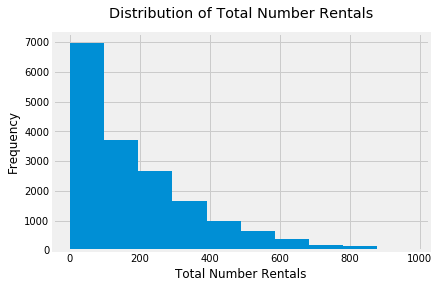

In [3]:
plt.hist(bike_rentals['cnt'])
plt.title('Distribution of Total Number Rentals', y=1.04)
plt.xlabel('Total Number Rentals')
plt.ylabel("Frequency")
plt.show()

The data is heavily right skewed, having around 7000 values between 0 and 100 rentals.

## 3. Correlation

The next step will be to find the correlations for feature selection.

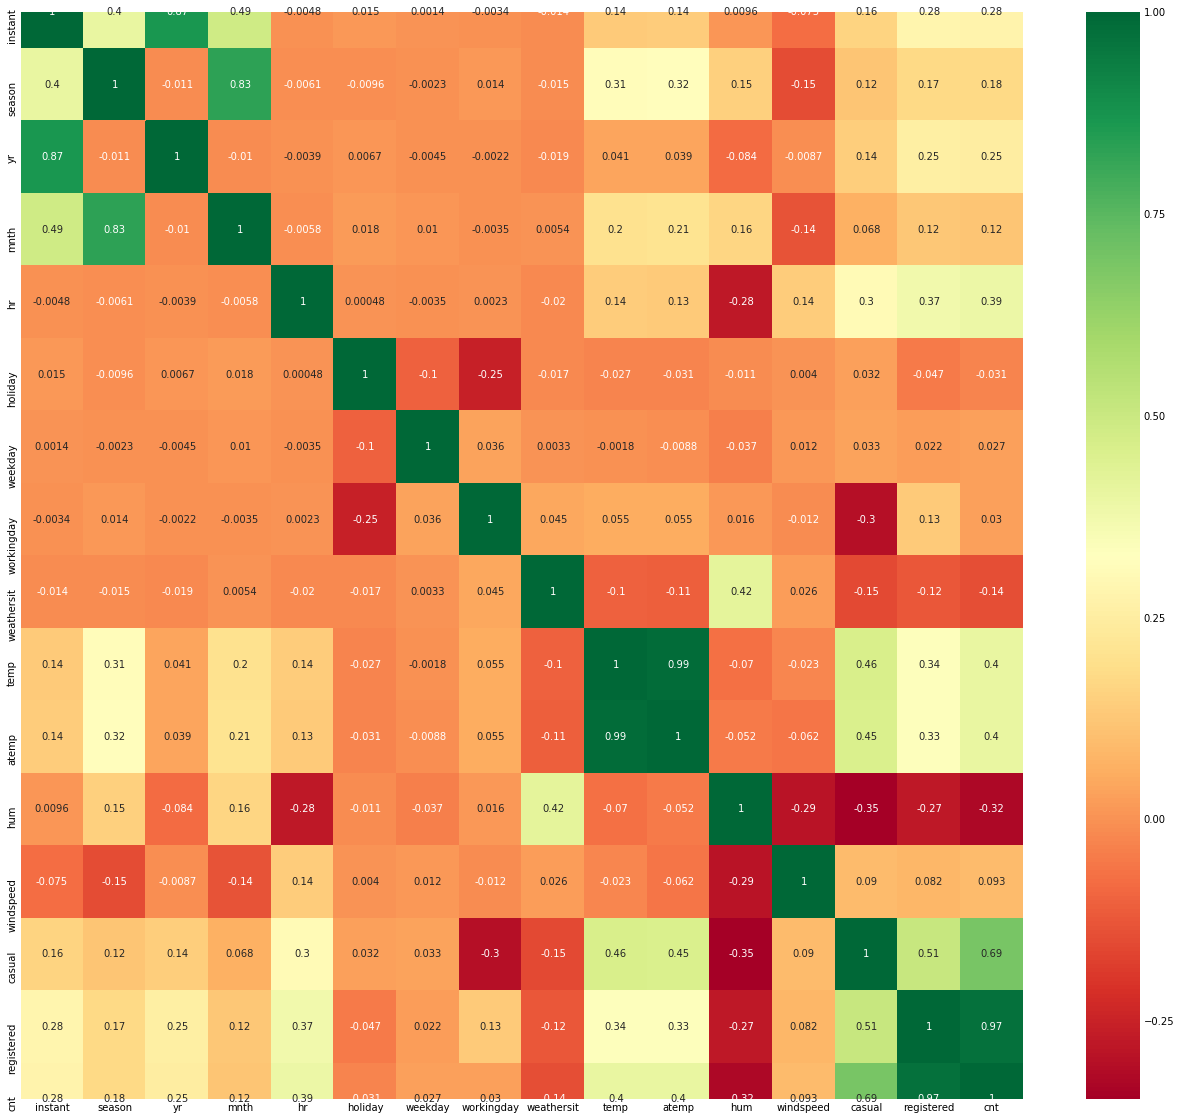

In [4]:
cnt_corr = bike_rentals.corr()['cnt']
top_corr_features = cnt_corr.index
plt.figure(figsize=(20, 20))
sns.heatmap(bike_rentals[top_corr_features].corr(), annot=True, cmap='RdYlGn')

In [5]:
cnt_corr_ordered = bike_rentals.corr()['cnt'].sort_values(ascending=False)
cnt_corr_ordered

cnt           1.000000
registered    0.972151
casual        0.694564
temp          0.404772
atemp         0.400929
hr            0.394071
instant       0.278379
yr            0.250495
season        0.178056
mnth          0.120638
windspeed     0.093234
workingday    0.030284
weekday       0.026900
holiday      -0.030927
weathersit   -0.142426
hum          -0.322911
Name: cnt, dtype: float64

The columns hr, atemp, temp, casual and registered seem to be the ones most correlated to the target `cnt` column.

## 4. Clean the Data

Let's also check if the data has any missing values:

In [6]:
bike_rentals.isnull().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

No missing values! It's good to have cleaner data for a change. But there is also one other thing to check: the hr column contains int data from 1 to 24, not easily correlating what is each period of the day. A machine will treat each hour differently, without understanding that certain hours are related. 

Let's transform this parameter to create something that the model can understand:

## 5. Calculate Features

We can introduce some order into the process by creating a new column with labels for morning, afternoon, evening, and night. This will bundle similar times together, enabling the model to make better decisions. The labels will be:

- from 6 to 12: 1 (morning)
- from 12 to 18: 2 (afternoon)
- from 18 to 24: 3 (evening)
- from 0 to 6: 4 (night)



In [7]:
def assign_label(row):
    """
     Takes in a numeric value for an hour, and returns:
    - 1 if the hour is from 6 to 12
    - 2 if the hour is from 12 to 18
    - 3 if the hour is from 18 to 24
    - 4 if the hour is from 0 to 6
    """
    
    if row >= 6 and row < 12:
        label = 1
    elif row >= 12 and row < 18:
        label = 2
    elif row >= 18 and row < 24:
        label = 3
    elif row >= 0 and row < 6:
        label = 4
    return label

bike_rentals['time_label'] = bike_rentals['hr'].apply(assign_label)
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,time_label
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16,4
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40,4
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32,4
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13,4
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1,4


Now that the data is clean and ready to use, we will select the error metrics that we need to analyze the performance of the machine learning algorithms. According to [this post in Towards Data Science](https://towardsdatascience.com/which-evaluation-metric-should-you-use-in-machine-learning-regression-problems-20cdaef258e) the ideal thing to do is use R2, MSE and RMSE. I'm going to report the 3 of them.

Having definied the error metrics, let's split our train and test samples using the sample method.

## 6. Split the Data

Before we can begin applying machine learning algorithms, we will need to split the data into training and testing sets. This will enable us to train an algorithm using the training set, and evaluate its accuracy on the testing set. If we train an algorithm on the training data, then evaluate its performance on the same data, we can get an unrealistically low error value, due to overfitting.

Let's split the dataframe in two:

- train - containing 80% of the rows from the original dataframe
- test - containing the remaining 20%

In [8]:
train = bike_rentals.sample(frac=0.8)
test = bike_rentals[~bike_rentals.index.isin(train.index)]

## 7. Machine Learning Models

Now that we have done some exploration and manipulation, we are ready to apply our machine learning models, and we will start with linear regression. 

### 7.1 Linear Regression

Linear regression will probably work fairly well on this data, given that many of the columns are highly correlated with cnt.

Let's start by creating a predictor columns list. We will exclude the cnt column as it is our target column. We will also exlude the casual and register columns as they make up the cnt column. The dteday column will aslo be removed.

In [9]:
features = bike_rentals.columns
features = features.drop(['dteday', 'casual', 'registered', 'cnt'])
target = 'cnt'

In [10]:
lr = LinearRegression()
lr.fit(train[features], train[target])

train_pred = lr.predict(train[features])
train_mse = mean_squared_error(train[target], train_pred)
train_rmse = np.sqrt(train_mse)
train_r2score = r2_score(train[target], train_pred)

test_pred = lr.predict(test[features])
test_mse = mean_squared_error(test[target], test_pred)
test_rmse = np.sqrt(test_mse)
test_r2score = r2_score(test[target], test_pred)
var1 = np.var(test_pred)

print("TRAIN ERRORS:")
print("MSE:", train_mse)
print("RMSE:", train_rmse)
print("R2 SCORE:", train_r2score)
print("-"*20)
print("TEST ERRORS:")
print("MSE:", test_mse)
print("RMSE:", test_rmse)
print("R2 SCORE:", test_r2score)

TRAIN ERRORS:
MSE: 17419.55943703363
RMSE: 131.98317861391894
R2 SCORE: 0.4724204312940973
--------------------
TEST ERRORS:
MSE: 17709.853884185075
RMSE: 133.07837496823095
R2 SCORE: 0.4538346683557962


The error is quite high. However, we see that the train and test error metrics are pretty close. That means that the model preforms equally on data it hasn't seen.

Let's remove columns with low correlation to `cnt`. Anything below 0.4 will be discarted (except negative ones).

### 7.2 Linear Regression - removing low correlation columns

In [11]:
feat = ['hum', 'weathersit', 'holiday', 'hr', 'atemp', 'temp']

lr = LinearRegression()
lr.fit(train[feat], train[target])

train_pred = lr.predict(train[feat])
train_mse = mean_squared_error(train[target], train_pred)
train_rmse = np.sqrt(train_mse)
train_r2score = r2_score(train[target], train_pred)

test_pred = lr.predict(test[feat])
test_mse = mean_squared_error(test[target], test_pred)
test_rmse = np.sqrt(test_mse)
test_r2score = r2_score(test[target], test_pred)
var2 = np.var(test_pred)

print("TRAIN ERRORS:")
print("MSE:", train_mse)
print("RMSE:", train_rmse)
print("R2 SCORE:", train_r2score)
print("-"*20)
print("TEST ERRORS:")
print("MSE:", test_mse)
print("RMSE:", test_rmse)
print("R2 SCORE:", test_r2score)

TRAIN ERRORS:
MSE: 22092.736897378578
RMSE: 148.6362570081021
R2 SCORE: 0.3308856836486781
--------------------
TEST ERRORS:
MSE: 22367.282500036727
RMSE: 149.55695403436354
R2 SCORE: 0.3102012955893855


The result was worse, but without overfitting or underfitting. This is probably close to the best result we can get with linear regression, and it might not be the best option for this data.

### 7.3 Decision Tree

Let's now try a Decision Tree model and see how well it performs.

In [12]:
clf = DecisionTreeRegressor(random_state=1)
clf.fit(train[features], train[target])

train_pred = clf.predict(train[features])
train_mse = mean_squared_error(train[target], train_pred)
train_rmse = np.sqrt(train_mse)
train_r2score = r2_score(train[target], train_pred)

test_pred = clf.predict(test[features])
test_mse = mean_squared_error(test[target], test_pred)
test_rmse = np.sqrt(test_mse)
test_r2score = r2_score(test[target], test_pred)
var3 = np.var(test_pred)

print("TRAIN ERRORS:")
print("MSE:", train_mse)
print("RMSE:", train_rmse)
print("R2 SCORE:", train_r2score)
print("-"*20)
print("TEST ERRORS:")
print("MSE:", test_mse)
print("RMSE:", test_rmse)
print("R2 SCORE:", test_r2score)

TRAIN ERRORS:
MSE: 0.0
RMSE: 0.0
R2 SCORE: 1.0
--------------------
TEST ERRORS:
MSE: 2975.8319907940163
RMSE: 54.55118688712479
R2 SCORE: 0.9082264440577437


Decision trees tend to predict outcomes much more reliably than linear regression models. Because a decision tree is a fairly complex model, it also tends to overfit, which is exatply what happened here as we can see from the MSE and RMSE for the train set.

That happens particularly when we don't tweak parameters like maximum depth and minimum number of samples per leaf. Decision trees are also prone to instability -- small changes in the input data can result in a very different output model.

### 7.4 Decision Tree - limiting the number of leafs allowed in the model

Let's try tweaking the minimum number of samples per leaf, the minimum number of rows a leaf must have to be considered a leaf. The standard number is 2, so we will make a for loop to go through all values between 2 and 10 samples:


Train Mean MSE: 1184.7179896040157
Test Mean MSE: 2840.660078966326
--------------------
Train Mean RMSE: 34.01738811127042
Test Mean RMSE: 53.29285828937216
--------------------
Train Mean R2SCORE: 0.9641188970218958
Test Mean R2SCORE: 0.912395095732407


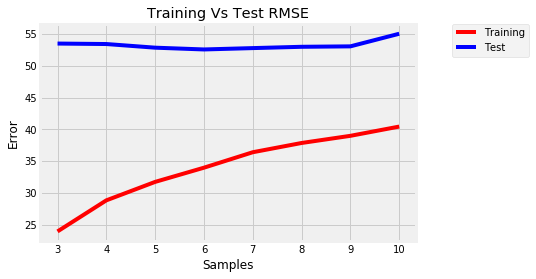

In [13]:
samples = [i for i in range(3,11)]
t_mse = []
t_rmse = []
t_r2score = []
tt_mse = []
tt_rmse = []
tt_r2score = []
tt_var4 = []


for i in samples:
    clf = DecisionTreeRegressor(random_state=1, min_samples_leaf=i)
    clf.fit(train[features], train[target])

    train_pred = clf.predict(train[features])
    train_mse = mean_squared_error(train[target], train_pred)
    train_rmse = np.sqrt(train_mse)
    train_r2score = r2_score(train[target], train_pred)
    t_r2score.append(train_r2score)
    t_rmse.append(train_rmse)
    t_mse.append(train_mse)

    test_pred = clf.predict(test[features])
    test_mse = mean_squared_error(test[target], test_pred)
    test_rmse = np.sqrt(test_mse)
    test_r2score = r2_score(test[target], test_pred)
    tt_r2score.append(test_r2score)
    tt_rmse.append(test_rmse)
    tt_mse.append(test_mse)
    tt_var = tt_var4.append(np.var(test_pred))

var4 = np.mean(tt_var4)
print("Train Mean MSE:", np.mean(t_mse))
print("Test Mean MSE:", np.mean(tt_mse))
print('-'*20)
print("Train Mean RMSE:", np.mean(t_rmse))
print("Test Mean RMSE:", np.mean(tt_rmse))
print('-'*20)
print("Train Mean R2SCORE:", np.mean(t_r2score))
print("Test Mean R2SCORE:", np.mean(tt_r2score))

plt.plot(samples, t_rmse, color="red")
plt.plot(samples, tt_rmse, color="blue")
plt.title("Training Vs Test RMSE")
plt.xlabel("Samples")
plt.ylabel("Error")
plt.legend(["Training", "Test"], bbox_to_anchor=(1.3,1), borderaxespad=0)

The high difference between the RMSE and MSE values for train and test sets may indicate overfitting.

### 7.5. Decision Tree - limiting the number of splits allowed in the model

Another parameter that can be tweaked is the min_samples_split, which represents the minimum number of rows a node should have before it can be split; if this is set to 2, for example, then nodes with 2 rows won't be split, and will become leaves instead.

The standard is 2. We will try from 3 to 10:


Train Mean MSE: 375.6361281937551
Test Mean MSE: 2810.9592226501272
--------------------
Train Mean RMSE: 18.525514656379567
Test Mean RMSE: 53.010522887620056
--------------------
Train Mean R2SCORE: 0.9886232515110862
Test Mean R2SCORE: 0.9133110591359526


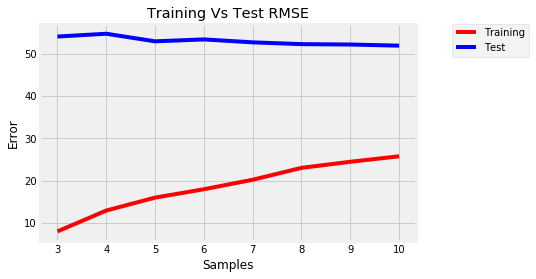

In [14]:
samples = [i for i in range(3,11)]
t_mse = []
t_rmse = []
t_r2score = []
tt_mse = []
tt_rmse = []
tt_r2score = []
tt_var5 = []

for i in samples:
    clf = DecisionTreeRegressor(random_state=1, min_samples_split=i)
    clf.fit(train[features], train[target])

    train_pred = clf.predict(train[features])
    train_mse = mean_squared_error(train[target], train_pred)
    train_rmse = np.sqrt(train_mse)
    train_r2score = r2_score(train[target], train_pred)
    t_r2score.append(train_r2score)
    t_rmse.append(train_rmse)
    t_mse.append(train_mse)

    test_pred = clf.predict(test[features])
    test_mse = mean_squared_error(test[target], test_pred)
    test_rmse = np.sqrt(test_mse)
    test_r2score = r2_score(test[target], test_pred)
    tt_r2score.append(test_r2score)
    tt_rmse.append(test_rmse)
    tt_mse.append(test_mse)
    tt_var = tt_var5.append(np.var(test_pred))

var5 = np.mean(tt_var5)
print("Train Mean MSE:", np.mean(t_mse))
print("Test Mean MSE:", np.mean(tt_mse))
print('-'*20)
print("Train Mean RMSE:", np.mean(t_rmse))
print("Test Mean RMSE:", np.mean(tt_rmse))
print('-'*20)
print("Train Mean R2SCORE:", np.mean(t_r2score))
print("Test Mean R2SCORE:", np.mean(tt_r2score))

plt.plot(samples, t_rmse, color="red")
plt.plot(samples, tt_rmse, color="blue")
plt.title("Training Vs Test RMSE")
plt.xlabel("Samples")
plt.ylabel("Error")
plt.legend(["Training", "Test"], bbox_to_anchor=(1.3,1), borderaxespad=0)

It seems the model did a little worse this time. Let's try another kind of model.

### 7.6 Random Forest

We will use 10 to 100 estimators, which means the number of times the model will be run in the data and ensembled together.

Train Mean MSE: 255.66638657779652
Test Mean MSE: 1878.6934377419968
--------------------
Train Mean RMSE: 15.972887067233017
Test Mean RMSE: 43.33858907819786
--------------------
Train Mean R2SCORE: 0.9922567294281537
Test Mean R2SCORE: 0.9420617905041874


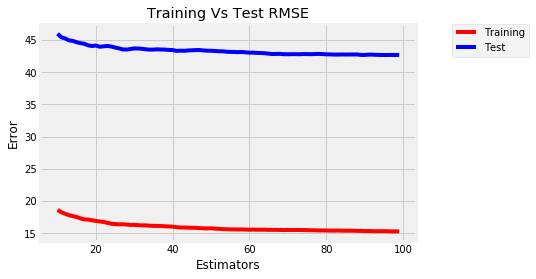

In [15]:
estimators = [i for i in range(10, 100)]
t_mse = []
t_rmse = []
t_r2score = []
tt_mse = []
tt_rmse = []
tt_r2score = []
tt_var6 = []

for i in estimators:
    clf = RandomForestRegressor(n_estimators=i, random_state=1)
    clf.fit(train[features], train[target])
    
    train_pred = clf.predict(train[features])
    train_mse = mean_squared_error(train[target], train_pred)
    t_mse.append(train_mse)
    train_rmse = np.sqrt(train_mse)
    t_rmse.append(train_rmse)
    train_r2score = r2_score(train[target], train_pred)
    t_r2score.append(train_r2score)
    
    test_pred = clf.predict(test[features])
    test_mse = mean_squared_error(test[target], test_pred)
    tt_mse.append(test_mse)
    test_rmse = np.sqrt(test_mse)
    tt_rmse.append(test_rmse)
    test_r2score = r2_score(test[target], test_pred)
    tt_r2score.append(test_r2score)
    tt_var = tt_var6.append(np.var(test_pred))

var6 = np.mean(tt_var6)    
print("Train Mean MSE:", np.mean(t_mse))
print("Test Mean MSE:", np.mean(tt_mse))
print('-'*20)
print("Train Mean RMSE:", np.mean(t_rmse))
print("Test Mean RMSE:", np.mean(tt_rmse))
print('-'*20)
print("Train Mean R2SCORE:", np.mean(t_r2score))
print("Test Mean R2SCORE:", np.mean(tt_r2score))

plt.plot(estimators, t_rmse, color="red")
plt.plot(estimators, tt_rmse, color="blue")
plt.title("Training Vs Test RMSE")
plt.xlabel("Estimators")
plt.ylabel("Error")
plt.legend(["Training", "Test"], bbox_to_anchor=(1.3,1), borderaxespad=0)

Doesn't look very good. It seems overfitted. And using 10 to 100 estimators takes a long time to run the model.

### 7.7 Random Forest - limiting the number of leafs allowed in the model and the number of estimators;

Let's use 2 to 10 samples in each leaf and 100 estimators

Train Mean MSE: 1048.4541256354937
Test Mean MSE: 2205.5219714146538
--------------------
Train Mean RMSE: 31.891058257469112
Test Mean RMSE: 46.91158541633825
--------------------
Train Mean R2SCORE: 0.9682458688229091
Test Mean R2SCORE: 0.9319825196275643


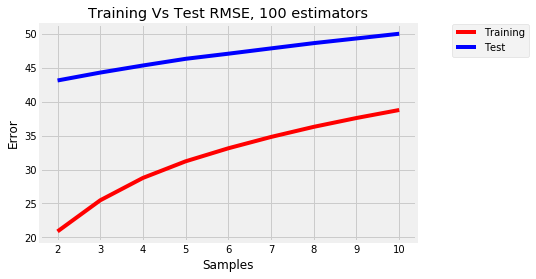

In [16]:
leafs = [a for a in range(2, 11)]
t_mse = []
t_rmse = []
t_r2score = []
tt_mse = []
tt_rmse = []
tt_r2score = []
tt_var7 = []

for i in leafs:
    clf = RandomForestRegressor(n_estimators=100, min_samples_leaf=i, random_state=1)
    clf.fit(train[features], train[target])
    
    train_pred = clf.predict(train[features])
    train_mse = mean_squared_error(train[target], train_pred)
    t_mse.append(train_mse)
    train_rmse = np.sqrt(train_mse)
    t_rmse.append(train_rmse)
    train_r2score = r2_score(train[target], train_pred)
    t_r2score.append(train_r2score)
    
    test_pred = clf.predict(test[features])
    test_mse = mean_squared_error(test[target], test_pred)
    tt_mse.append(test_mse)
    test_rmse = np.sqrt(test_mse)
    tt_rmse.append(test_rmse)
    test_r2score = r2_score(test[target], test_pred)
    tt_r2score.append(test_r2score)
    tt_var = tt_var7.append(np.var(test_pred))

var7 = np.mean(tt_var7)
    
print("Train Mean MSE:", np.mean(t_mse))
print("Test Mean MSE:", np.mean(tt_mse))
print('-'*20)
print("Train Mean RMSE:", np.mean(t_rmse))
print("Test Mean RMSE:", np.mean(tt_rmse))
print('-'*20)
print("Train Mean R2SCORE:", np.mean(t_r2score))
print("Test Mean R2SCORE:", np.mean(tt_r2score))

plt.plot(leafs, t_rmse, color="red")
plt.plot(leafs, tt_rmse, color="blue")
plt.title("Training Vs Test RMSE, 100 estimators")
plt.xlabel("Samples")
plt.ylabel("Error")
plt.legend(["Training", "Test"], bbox_to_anchor=(1.3,1), borderaxespad=0)

### 7.8 Random Forest - limiting the number of splits allowed in the model

Let's also change min_samples_split to go from 3 to 10.

Train Mean MSE: 485.70161264672606
Test Mean MSE: 1880.2982255821441
--------------------
Train Mean RMSE: 21.803547995211993
Test Mean RMSE: 43.36039815507399
--------------------
Train Mean R2SCORE: 0.985289740062246
Test Mean R2SCORE: 0.9420122994418294


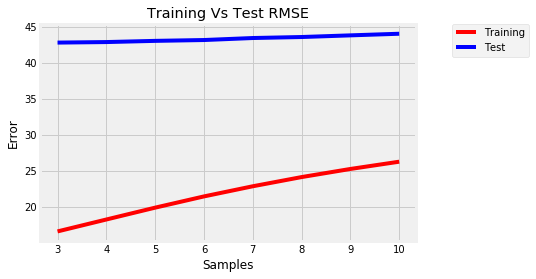

In [17]:
leafs = [a for a in range(3, 11)]
t_mse = []
t_rmse = []
t_r2score = []
tt_mse = []
tt_rmse = []
tt_r2score = []
tt_var8 = []

for i in leafs:
    clf = RandomForestRegressor(n_estimators=100, min_samples_split=i, random_state=1)
    clf.fit(train[features], train[target])
    
    train_pred = clf.predict(train[features])
    train_mse = mean_squared_error(train[target], train_pred)
    t_mse.append(train_mse)
    train_rmse = np.sqrt(train_mse)
    t_rmse.append(train_rmse)
    train_r2score = r2_score(train[target], train_pred)
    t_r2score.append(train_r2score)
    
    test_pred = clf.predict(test[features])
    test_mse = mean_squared_error(test[target], test_pred)
    tt_mse.append(test_mse)
    test_rmse = np.sqrt(test_mse)
    tt_rmse.append(test_rmse)
    test_r2score = r2_score(test[target], test_pred)
    tt_r2score.append(test_r2score)
    tt_var = tt_var8.append(np.var(test_pred))

var8 = np.mean(tt_var8)
    
print("Train Mean MSE:", np.mean(t_mse))
print("Test Mean MSE:", np.mean(tt_mse))
print('-'*20)
print("Train Mean RMSE:", np.mean(t_rmse))
print("Test Mean RMSE:", np.mean(tt_rmse))
print('-'*20)
print("Train Mean R2SCORE:", np.mean(t_r2score))
print("Test Mean R2SCORE:", np.mean(tt_r2score))

plt.plot(leafs, t_rmse, color="red")
plt.plot(leafs, tt_rmse, color="blue")
plt.title("Training Vs Test RMSE")
plt.xlabel("Samples")
plt.ylabel("Error")
plt.legend(["Training", "Test"], bbox_to_anchor=(1.3,1), borderaxespad=0)

## 8. Final Comparisson

This step will be directed at comparing the results from each of the 8 models we implemented. To do that, we will compare the metrics for each of them to find the lowest errors.

The errors will be compared in the 2 next steps, but more than the errors alone, some things must be highlighted:

Although some other models show lower errors they seem overfitted because of too high r square and higher training error than validation error. This result has been achieved by applying trade-off between the following criteria:

- lower RSME
- lower difference between training and validation errors to prevent overfitting
- high R square but not too high to find the fitted algorithm but not overfitted one.

## 9. RMSE, MSE and Variance

Text(0.5, 1.03, 'RMSE per Model')

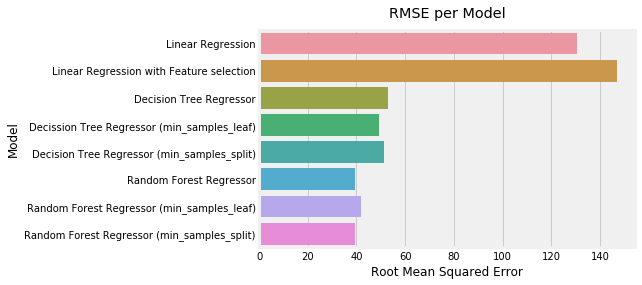

In [18]:
test_rmse_errors = [130.43417701810935, 146.99156377410608, 52.93185307728823,
                   49.23922692755616, 51.1419308010816, 39.24513000090896,
                    41.89456033149276,  39.566599321631315]

models = ['Linear Regression', 'Linear Regression with Feature selection',
         'Decision Tree Regressor', 'Decission Tree Regressor (min_samples_leaf)',
         'Decision Tree Regressor (min_samples_split)', 'Random Forest Regressor',
         'Random Forest Regressor (min_samples_leaf)',
          'Random Forest Regressor (min_samples_split)']

ax = plt.subplot()
sns.barplot(test_rmse_errors, models, orient='h')
plt.xlabel('Root Mean Squared Error')
plt.ylabel('Model')
plt.title('RMSE per Model', y=1.03)

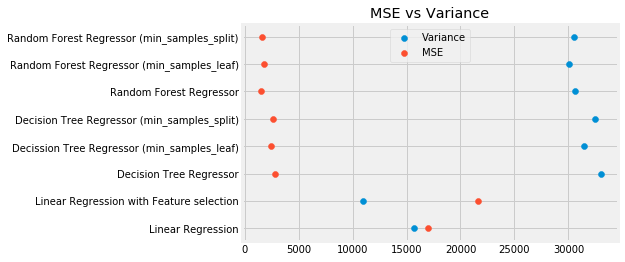

In [19]:
var_tot = [var1, var2, var3, var4, var5, var6, var7, var8]
test_mse_errors = [17013.074534391482, 21606.519820757094 , 2801.7810701956273 ,
                   2424.856442781705 , 2616.4810710562665 , 1540.4121157138704 ,
                    1757.8226508700593 , 1565.7011320824017]

models = np.array(models)
plt.scatter(x=var_tot, y=models, label='Variance')
plt.scatter(x=test_mse_errors, y=models, label='MSE')
plt.legend(loc='upper center')
plt.title('MSE vs Variance')
plt.show()

## 10. Conclusion and Next Steps

RandomForest is the best model to reach predition accuracy. While the random forest algorithm is incredibly powerful, it isn't applicable to all tasks.

The main strengths of a random forest are:

- Very accurate predictions - Random forests achieve near state-of-the-art performance on many machine learning tasks. Along with neural networks and gradient-boosted trees, they're typically one of the top-performing algorithms.
- Resistance to overfitting - Due to their construction, random forests are fairly resistant to overfitting. We still need to set and tweak parameters like max_depth though.

The main weaknesses of using a random forest are:

- They're difficult to interpret - Because we're averaging the results of many trees, it can be hard to figure out why a random forest is making predictions the way it is.
- They take longer to create - Making two trees takes twice as long as making one, making three takes three times as long, and so on. Fortunately, we can exploit multicore processors to parallelize tree construction. Scikit allows us to do this through the n_jobs parameter on RandomForestClassifier.

Decision Trees models could be improved by tweaking the parameters, however Random Forest models slightly increased the values. 

For Linear Regression working in the improvement of the best features did not show an improvement in error metrics.

Next steps: Here are some potential next steps:

- Calculate additional features, such as:
    - An index combining temperature, humidity, and wind speed
- Try predicting casual and registered instead of cnt
- Use Adjusted R-Squared and Predicted R-Squared in Regression Analysis